In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from statsmodels.tools.tools import add_constant
import os

# Sklearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Helper Functions
from function import date_time_convertion, list_to_cols
import warnings
warnings.filterwarnings('ignore')

# Getting Started

1. Download the data, if not already in the current directory
Wget may not work, so visit https://drive.google.com/file/d/1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE/view?usp=sharing to downlaod the data from google drive

In [2]:
if 'KuaiRec 2.0' not in os.listdir() and 'data' not in os.listdir():
    # !wget 'https://docs.google.com/uc?export=download&id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE' --no-check-certificate -O data.zip
    print('Data file not found!')
    if 'KuaiRec 2.0.zip' in os.listdir():
        print('Zipfile found. Unziping')
        !unzip 'KuaiRec.zip' -d ./

2. Switch to the KuaiRec directory

In [3]:
DIR = "KuaiRec 2.0/"
if 'data' not in os.listdir():
    os.chdir(DIR)
rootpath="./"
print(rootpath)

./


In [4]:
# print("Loading big matrix...")
# big_matrix = pd.read_csv(rootpath + "data/big_matrix.csv")
print("Loading small matrix...")
small_matrix = pd.read_csv(rootpath + "data/small_matrix.csv")

print("Loading social network...")
social_network = pd.read_csv(rootpath + "data/social_network.csv")
social_network["friend_list"] = social_network["friend_list"].map(eval)

print("Loading item features...")
item_categories = pd.read_csv(rootpath + "data/item_categories.csv")
item_categories["feat"] = item_categories["feat"].map(eval)

print("Loading user features...")
user_features = pd.read_csv("data/user_features.csv")

print("Loading items' daily features...")
item_daily_features = pd.read_csv("data/item_daily_features.csv")

print("Loading video category...")
video_categories = pd.read_csv("data/kuairec_caption_category.csv",
                               engine="python",
                               usecols=["video_id",
                                        "first_level_category_id",
                                        "second_level_category_id",
                                        "third_level_category_id"]
                              )
user_features = pd.read_csv("data/user_features.csv", usecols=[0] + list(range(13, 31)))

print("All data loaded.")

Loading small matrix...
Loading social network...
Loading item features...
Loading user features...
Loading items' daily features...
Loading video category...
All data loaded.


## Data Exploration

Since we are mainly work with small_matrix our explorations are going to focus on that dataset.

In [5]:
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


In [6]:
# sum([True for idx, row in small_matrix.iterrows() if any(row.isnull())])
print(f"Small Matrix shape: {small_matrix.shape}")
rows_wnans = small_matrix.shape[0] - small_matrix.dropna().shape[0]
print(f"There are {rows_wnans} rows with NaNs")

Small Matrix shape: (4676570, 8)
There are 181992 rows with NaNs


Since there are 181991 rows that have NaNs we will impute them in order not to lose valuable data. We could the compare how our results differe if we were to only drop these rows or impute them.

In [7]:
video_categories.head()

,video_id,first_level_category_id,second_level_category_id,third_level_category_id
0,0,8.0,673.0,-124.0
1,1,27.0,-124.0,-124.0
2,2,9.0,727.0,-124.0
3,3,26.0,686.0,2434.0
4,4,5.0,737.0,2596.0


In [8]:
video_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10732 entries, 0 to 10731
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_id                  10731 non-null  object 
 1   first_level_category_id   10728 non-null  float64
 2   second_level_category_id  10728 non-null  float64
 3   third_level_category_id   10724 non-null  float64
dtypes: float64(3), object(1)
memory usage: 335.5+ KB


In [9]:
print(len(video_categories["video_id"].unique()))

10731


In [10]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7176 entries, 0 to 7175
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        7176 non-null   int64  
 1   onehot_feat0   7176 non-null   int64  
 2   onehot_feat1   7176 non-null   int64  
 3   onehot_feat2   7176 non-null   int64  
 4   onehot_feat3   7176 non-null   int64  
 5   onehot_feat4   6975 non-null   float64
 6   onehot_feat5   7176 non-null   int64  
 7   onehot_feat6   7176 non-null   int64  
 8   onehot_feat7   7176 non-null   int64  
 9   onehot_feat8   7176 non-null   int64  
 10  onehot_feat9   7176 non-null   int64  
 11  onehot_feat10  7176 non-null   int64  
 12  onehot_feat11  7176 non-null   int64  
 13  onehot_feat12  7099 non-null   float64
 14  onehot_feat13  7101 non-null   float64
 15  onehot_feat14  7101 non-null   float64
 16  onehot_feat15  7102 non-null   float64
 17  onehot_feat16  7102 non-null   float64
 18  onehot_f

In [11]:
user_features.isna().sum()

user_id            0
onehot_feat0       0
onehot_feat1       0
onehot_feat2       0
onehot_feat3       0
onehot_feat4     201
onehot_feat5       0
onehot_feat6       0
onehot_feat7       0
onehot_feat8       0
onehot_feat9       0
onehot_feat10      0
onehot_feat11      0
onehot_feat12     77
onehot_feat13     75
onehot_feat14     75
onehot_feat15     74
onehot_feat16     74
onehot_feat17     74
dtype: int64

In [12]:
user_features.drop(['onehot_feat4', 'onehot_feat12',
                    'onehot_feat13', 'onehot_feat14',
                   'onehot_feat15', 'onehot_feat16', 'onehot_feat17'], axis=1, inplace=True)

In [13]:
user_features.isna().sum()

user_id          0
onehot_feat0     0
onehot_feat1     0
onehot_feat2     0
onehot_feat3     0
onehot_feat5     0
onehot_feat6     0
onehot_feat7     0
onehot_feat8     0
onehot_feat9     0
onehot_feat10    0
onehot_feat11    0
dtype: int64

## Data Preparation

#### Convert Date time to integers

In [14]:
import pandas as pd
import numpy as np
import datetime as dt

def date_time_convertion(col):
    col = pd.to_datetime(col)
    min_col = col.min()
    for idx, value in enumerate(col):
        new_val = (value - min_col).total_seconds()
        col.iloc[idx] = new_val
    return col

small_matrix["time"] = date_time_convertion(small_matrix["time"])

#### Process NaN

In [15]:
# Keep only rows with numeric "video_id"
video_categories = video_categories[video_categories["video_id"].astype(str).str.isnumeric()]

In [16]:
video_categories.loc[:, "video_id"] = video_categories["video_id"].astype(int)

In [17]:
print(len(video_categories["video_id"].unique()))

10728


In [18]:
video_categories.isna().sum()

video_id                    0
first_level_category_id     4
second_level_category_id    4
third_level_category_id     4
dtype: int64

In [19]:
np.sort(video_categories["first_level_category_id"].unique())

array([-124.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   nan])

In [20]:
# Replace NaN values with -124 (unknown)
video_categories.loc[:, ["first_level_category_id", "second_level_category_id", "third_level_category_id"]] = \
    video_categories[["first_level_category_id", "second_level_category_id", "third_level_category_id"]].fillna(-124)

In [21]:
video_categories.isna().sum()

video_id                    0
first_level_category_id     0
second_level_category_id    0
third_level_category_id     0
dtype: int64

In [22]:
video_categories.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10728 entries, 0 to 10731
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_id                  10728 non-null  object 
 1   first_level_category_id   10728 non-null  float64
 2   second_level_category_id  10728 non-null  float64
 3   third_level_category_id   10728 non-null  float64
dtypes: float64(3), object(1)
memory usage: 419.1+ KB


#### Merge Datasets

In [23]:
# merged_df = pd.merge(small_matrix, item_categories, on="video_id", how="left")
# print(merged_df.shape)

# # merged_df = pd.merge(small_matrix, item_categories, on="video_id", how="inner")
# # print(merged_df.shape) 
# # This to ensure that every video_id in small_matrix is also in item_categories

# merged_df = pd.merge(merged_df, social_network, on="user_id", how="left")
# print(merged_df.shape)

# # merged_df = pd.merge(small_matrix, social_network, on="user_id", how="inner")
# # print(merged_df.shape) 


In [24]:
small_matrix_merged = (
    small_matrix
    .merge(item_categories, on="video_id", how="left")
    .merge(video_categories[["video_id", "first_level_category_id", "second_level_category_id", "third_level_category_id"]], on = "video_id", how = "left")
    # .merge(social_network, on="user_id", how="left")
)
display(small_matrix_merged.head())

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,feat,first_level_category_id,second_level_category_id,third_level_category_id
0,14,148,4381,6067,97462.318,20200705.0,1.593898e+09,0.722103,"[11, 28, 19]",19.0,744.0,2636.0
1,14,183,11635,6100,97473.997,20200705.0,1.593898e+09,1.907377,[28],28.0,223.0,-124.0
2,14,3649,22422,10867,97543.419,20200705.0,1.593898e+09,2.063311,[9],28.0,223.0,1830.0
3,14,5262,4479,7908,97637.225,20200705.0,1.593898e+09,0.566388,[25],5.0,735.0,-124.0
4,14,8234,4602,11000,97937.399,20200705.0,1.593899e+09,0.418364,[6],6.0,667.0,2375.0


In [25]:
small_matrix_merged.isna().sum()

user_id                          0
video_id                         0
play_duration                    0
video_duration                   0
time                        181992
date                        181992
timestamp                   181992
watch_ratio                      0
feat                             0
first_level_category_id          0
second_level_category_id         0
third_level_category_id          0
dtype: int64

In [26]:
small_matrix_merged = list_to_cols(small_matrix_merged, "feat")

#### Data Imputation

In [27]:
# KNN Imputation
# imputer = KNNImputer(n_neighbors=20)
# df_filled = imputer.fit_transform(small_matrix)

# Median/Mean/Mode Imputation
for col in small_matrix_merged.columns:
    small_matrix_merged[col] = small_matrix_merged[col].fillna(small_matrix_merged[col].median()) # median() or mode()[0]
display(small_matrix_merged)    

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,first_level_category_id,second_level_category_id,third_level_category_id,feat_1,feat_2,feat_3,feat_4
0,14,148,4381,6067,97462.318,20200705.0,1.593898e+09,0.722103,19.0,744.0,2636.0,11,28.0,19.0,0.0
1,14,183,11635,6100,97473.997,20200705.0,1.593898e+09,1.907377,28.0,223.0,-124.0,28,0.0,0.0,0.0
2,14,3649,22422,10867,97543.419,20200705.0,1.593898e+09,2.063311,28.0,223.0,1830.0,9,0.0,0.0,0.0
3,14,5262,4479,7908,97637.225,20200705.0,1.593898e+09,0.566388,5.0,735.0,-124.0,25,0.0,0.0,0.0
4,14,8234,4602,11000,97937.399,20200705.0,1.593899e+09,0.418364,6.0,667.0,2375.0,6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,2423337.210,20200801.0,1.596224e+09,2.178160,25.0,235.0,1272.0,25,0.0,0.0,0.0
4676566,7162,2065,11919,6067,2423337.210,20200801.0,1.596224e+09,1.964562,29.0,689.0,2455.0,9,17.0,0.0,0.0
4676567,7162,1296,16690,19870,2423337.210,20200801.0,1.596224e+09,0.839960,1.0,722.0,2544.0,1,5.0,0.0,0.0
4676568,7162,4822,11862,24400,2423337.210,20200801.0,1.596224e+09,0.486148,9.0,136.0,-124.0,9,0.0,0.0,0.0


#### Data transformation

In [28]:
small_transformed_df = small_matrix_merged.pivot_table(index='user_id', 
                                           columns='first_level_category_id', 
                                           values='watch_ratio', 
                                           aggfunc='sum')  

In [29]:
small_transformed_df.head()

first_level_category_id,-124.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,4.286082,143.114573,18.780785,3.990782,23.204983,127.466564,226.189900,154.046108,274.076947,104.960823,...,29.057355,53.299769,28.284356,86.550536,189.378020,34.154832,5.654891,10.072252,2.747260,16.204715
19,2.181404,114.764137,15.067363,4.878045,26.105601,110.512886,184.396166,125.246851,260.217647,91.961913,...,25.413421,46.104619,25.111988,78.931972,143.146660,34.819603,5.125674,7.942315,1.003059,6.220014
21,2.926339,124.110059,23.230539,5.624282,27.482122,130.194884,240.155861,142.008902,289.964595,93.602000,...,25.204688,49.205301,24.432978,84.570179,155.033386,33.616927,6.429626,10.021961,1.276294,6.761944
23,3.981672,107.067355,26.635610,6.181167,20.649301,131.889982,191.524655,154.143455,317.001194,124.566335,...,31.547009,41.461490,28.913310,95.215205,150.692951,53.090773,5.192854,11.549175,1.235337,5.550794
24,2.684146,89.313163,13.462446,5.342142,26.527966,132.614202,178.508812,113.466052,323.619663,91.335295,...,18.917689,47.151678,23.701717,76.580128,136.945069,28.144926,4.843280,12.512766,1.326224,8.001600


In [30]:
small_transformed_merged_df = (
    user_features
    .merge(small_transformed_df, on="user_id", how="right")
)

In [31]:
small_transformed_merged_df.isna().sum()

 user_id          0
 onehot_feat0     0
 onehot_feat1     0
 onehot_feat2     0
 onehot_feat3     0
 onehot_feat5     0
 onehot_feat6     0
 onehot_feat7     0
 onehot_feat8     0
 onehot_feat9     0
 onehot_feat10    0
 onehot_feat11    0
-124.0            0
 1.0              0
 2.0              0
 3.0              0
 4.0              0
 5.0              0
 6.0              0
 7.0              0
 8.0              0
 9.0              0
 10.0             0
 11.0             0
 12.0             0
 13.0             0
 14.0             0
 15.0             0
 16.0             0
 17.0             0
 18.0             0
 19.0             0
 20.0             0
 21.0             0
 22.0             0
 23.0             0
 25.0             0
 26.0             0
 27.0             0
 28.0             0
 29.0             0
 31.0             0
 32.0             0
 33.0             0
 34.0             0
 35.0             0
 36.0             0
 37.0             0
 38.0             0
 39.0             0


In [32]:
small_transformed_merged_df.set_index('user_id', inplace = True)

In [33]:
small_transformed_merged_df = add_constant(small_transformed_merged_df)

In [34]:
small_transformed_merged_df.head()

,const,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,...,29.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
user_id,,,,,,,,,,,,,,,,,,,,,
14,1.0,0,5,8,417,0,1,3,297,4,...,29.057355,53.299769,28.284356,86.550536,189.378020,34.154832,5.654891,10.072252,2.747260,16.204715
19,1.0,0,1,18,589,0,1,7,227,3,...,25.413421,46.104619,25.111988,78.931972,143.146660,34.819603,5.125674,7.942315,1.003059,6.220014
21,1.0,0,4,13,568,0,0,13,292,4,...,25.204688,49.205301,24.432978,84.570179,155.033386,33.616927,6.429626,10.021961,1.276294,6.761944
23,1.0,0,1,3,45,0,0,13,148,6,...,31.547009,41.461490,28.913310,95.215205,150.692951,53.090773,5.192854,11.549175,1.235337,5.550794
24,1.0,1,4,17,634,0,1,0,64,5,...,18.917689,47.151678,23.701717,76.580128,136.945069,28.144926,4.843280,12.512766,1.326224,8.001600


#### Train-Test Split

In [35]:
X = small_matrix_merged.drop(columns=["watch_ratio"])
y = small_matrix_merged["watch_ratio"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=2024, shuffle=True)

In [37]:
X_trans = small_transformed_merged_df

In [38]:
X_trans_train, X_trans_test = train_test_split(X_trans, test_size=0.18, random_state=2024, shuffle=True)

### MAB - LinUCB

In [39]:
print(X_trans_train.columns)

Index([        'const',  'onehot_feat0',  'onehot_feat1',  'onehot_feat2',
        'onehot_feat3',  'onehot_feat5',  'onehot_feat6',  'onehot_feat7',
        'onehot_feat8',  'onehot_feat9', 'onehot_feat10', 'onehot_feat11',
                -124.0,             1.0,             2.0,             3.0,
                   4.0,             5.0,             6.0,             7.0,
                   8.0,             9.0,            10.0,            11.0,
                  12.0,            13.0,            14.0,            15.0,
                  16.0,            17.0,            18.0,            19.0,
                  20.0,            21.0,            22.0,            23.0,
                  25.0,            26.0,            27.0,            28.0,
                  29.0,            31.0,            32.0,            33.0,
                  34.0,            35.0,            36.0,            37.0,
                  38.0,            39.0],
      dtype='object')


In [40]:
arm_ids = small_matrix_merged["first_level_category_id"].unique()
print("Number of arms:", len(arm_ids))
print(np.sort(arm_ids))

Number of arms: 38
[-124.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   25.   26.   27.   28.   29.   31.   32.   33.   34.   35.   36.   37.
   38.   39.]


In [41]:
print("Number of context features:", user_features.shape[1]-1)

Number of context features: 11


In [42]:
class Linear_Bandit:
    def __init__(self, arms, features):
        self.K = arms 
        self.D = features
        self.params = np.random.rand(self.K, self.D+1)
    
    def gen_contexts(self):
        self.contexts = np.random.rand(self.K, self.D)
        self.contexts = add_constant(self.contexts)
        return self.contexts
    
    def pull_arm(self, i):
        return np.sum(self.contexts[i]*self.params[i]) + np.random.random()

    def compute_regret(self, i):
        all_rewards = np.sum(self.contexts * self.params, axis=1)
        return np.max(all_rewards) - all_rewards[i]

def compute_ucb(x, A, b, alpha):
    UCB = []
    for i in range(len(b)):
        Ainv = np.linalg.inv(A[i])
        Rhat = x @ Ainv @ b[i]
        Uhat = alpha * np.sqrt(x.T @ Ainv @ x)
        UCB.append(Rhat + Uhat)
    return np.array(UCB)

def linucb(alpha, trials, X, A = None, b = None, num_arm = 38, num_features = 11):
    K = num_arm
    D = num_features # -1?? Also with or without "watch_ratio"
    if A == None:
        A = [np.eye(D+1) for i in range(K)]
    if b == None:
        b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(trials)
    values_of_idx = []
    
    for i in range(trials):
        # Get Data
        user = X.sample(n=1).values.flatten()
        x = user[:D+1]
        rewards = user[D+1:]
        
        # Pull Arm
        UCB = compute_ucb(x, A, b, alpha)
        idx = np.argmax(UCB)
        reward = rewards[idx]

        # Update A and b
        A[idx] += np.outer(x, x)
        b[idx] += reward * x

        # Compute Regret
        regret[i] = np.max(rewards) - reward
    return A, b, regret

def linucb_test(alpha, X, A = None, b = None, num_arm = 38, num_features = 11):
    K = num_arm
    D = num_features # -1?? Also with or without "watch_ratio"
    if A == None:
        A = [np.eye(D+1) for i in range(K)]
    if b == None:
        b = [np.zeros(D+1) for i in range(K)]
    regret = np.zeros(X.shape[0])
    values_of_idx = []
    
    i = 0
    for index, user in X.iterrows():
        # Get Data
        user = user.values.flatten()
        x = user[:D+1]
        rewards = user[D+1:]
        
        # Pull Arm
        UCB = compute_ucb(x, A, b, alpha)
        idx = np.argmax(UCB)
        reward = rewards[idx]

        # Update A and b
        #A[idx] += np.outer(x, x)
        #b[idx] += reward * x

        # Compute Regret
        regret[i] = np.max(rewards) - reward
        i += 1
    return A, b, regret

In [43]:
print(X_trans_train.shape)

(1157, 50)


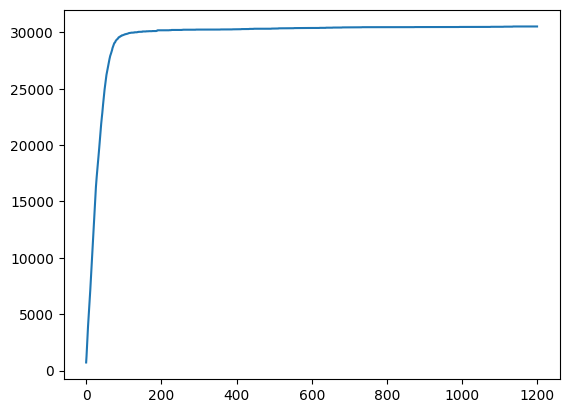

In [44]:
trials, sims, alpha = 1200, 50, 1
avg_regret = np.zeros(trials)

for m in range(sims):
    A_train, b_train, regret = linucb(alpha, trials, X_trans_train, num_arm = 38, num_features = 11)
    avg_regret += regret 
avg_regret /= sims

plt.plot(np.cumsum(avg_regret))
plt.show()

In [45]:
A_test, b_test, regret_test = linucb_test(alpha, X_trans_test,
                                      A = A_train, b = b_train,
                                      num_arm = 38, num_features = 11)

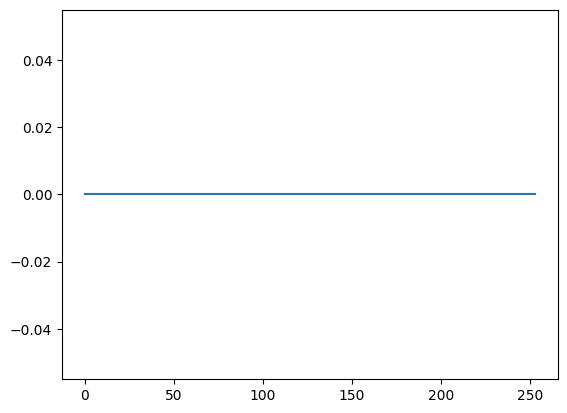

In [46]:
plt.plot(regret_test)